# SARIMA Corporate Sales Forcasting

### Import Python Libraries and Formatting

In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot") 
from datetime import datetime, timedelta, date

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

### Import Data into Dataframes

In [70]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [71]:
dfs = [train, test]

In [72]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [73]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


### Data Wrangling

#### Data Types

In [78]:
for i, df in enumerate(dfs):
    print(df.dtypes)
    print("")

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
dtype: object

Store         int64
Dept          int64
Date         object
IsHoliday      bool
dtype: object



In [79]:
for df in dfs:
    df["Date"] = df["Date"].astype("datetime64[ns]")

In [80]:
for i, df in enumerate(dfs):
    print(df.dtypes)
    print("")

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
dtype: object

Store                 int64
Dept                  int64
Date         datetime64[ns]
IsHoliday              bool
dtype: object



#### NULL Values

In [81]:
for df in dfs:
    print(df.isnull().sum())
    print("")

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

Store        0
Dept         0
Date         0
IsHoliday    0
dtype: int64



#### Duplicate Values

In [82]:
for df in dfs:
    print(df.duplicated().sum())
    print("")

0

0



#### Zero Values

In [89]:
for df in dfs:
    for i in range(len(df)):
        for col in df.columns[0:len(df.columns)-1]:
            if df.loc[i, col] == 0:
                print(df[i:i+1])

      Store  Dept       Date  Weekly_Sales  IsHoliday
6055      1    47 2011-03-11           0.0      False
      Store  Dept       Date  Weekly_Sales  IsHoliday
6059      1    47 2011-08-12           0.0      False
      Store  Dept       Date  Weekly_Sales  IsHoliday
6060      1    47 2011-08-19           0.0      False
       Store  Dept       Date  Weekly_Sales  IsHoliday
16309      2    47 2012-04-13           0.0      False
       Store  Dept       Date  Weekly_Sales  IsHoliday
17457      2    60 2010-03-19           0.0      False
       Store  Dept       Date  Weekly_Sales  IsHoliday
25448      3    36 2012-08-17           0.0      False
       Store  Dept       Date  Weekly_Sales  IsHoliday
56663      6    78 2010-02-26           0.0      False
       Store  Dept       Date  Weekly_Sales  IsHoliday
64921      7    49 2011-06-17           0.0      False
       Store  Dept       Date  Weekly_Sales  IsHoliday
65215      7    54 2011-01-21           0.0      False
       Store  De

#### New Date Features

In [95]:
import calendar
for df in dfs:
    df["Month"] = df["Date"].dt.month.apply(lambda x: calendar.month_abbr[x])
    df["Year"] = df["Date"].dt.year

In [96]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Month,Year
0,1,1,2010-02-05,24924.50,False,Feb,2010
1,1,1,2010-02-12,46039.49,True,Feb,2010
2,1,1,2010-02-19,41595.55,False,Feb,2010
3,1,1,2010-02-26,19403.54,False,Feb,2010
4,1,1,2010-03-05,21827.90,False,Mar,2010


In [97]:
test.head()

,Store,Dept,Date,IsHoliday,Month,Year
0,1,1,2012-11-02,False,Nov,2012
1,1,1,2012-11-09,False,Nov,2012
2,1,1,2012-11-16,False,Nov,2012
3,1,1,2012-11-23,True,Nov,2012
4,1,1,2012-11-30,False,Nov,2012


### Exploratory Data Analysis

#### Distribution of Stores and Departments

C:\Users\ikant\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ikant\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ikant\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

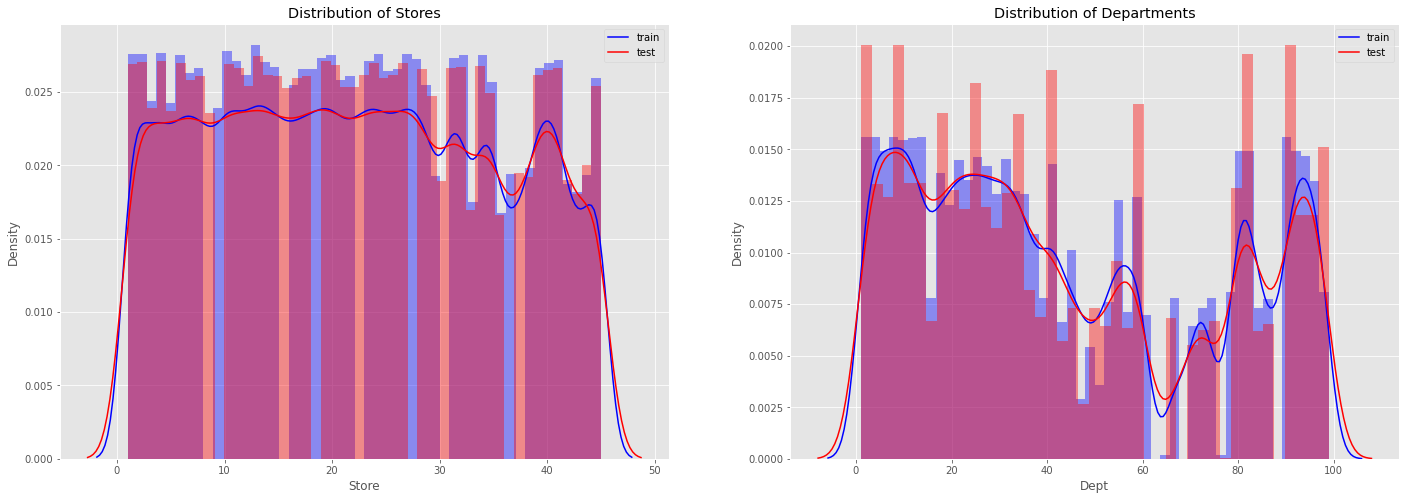

In [112]:
fig, ax = plt.subplots(1, 2, figsize = (24, 8))

sns.distplot(train["Store"], color = "blue", ax = ax[0])
sns.distplot(test["Store"], color = "red", ax = ax[0])
ax[0].legend(["train", "test"])
ax[0].set_title("Distribution of Stores")

sns.distplot(train["Dept"], color = "blue", ax = ax[1])
sns.distplot(test["Dept"], color = "red", ax = ax[1])
ax[1].legend(["train", "test"])
ax[1].set_title("Distribution of Departments")

plt.show()

#### Weekly Sales by Department in Store 1

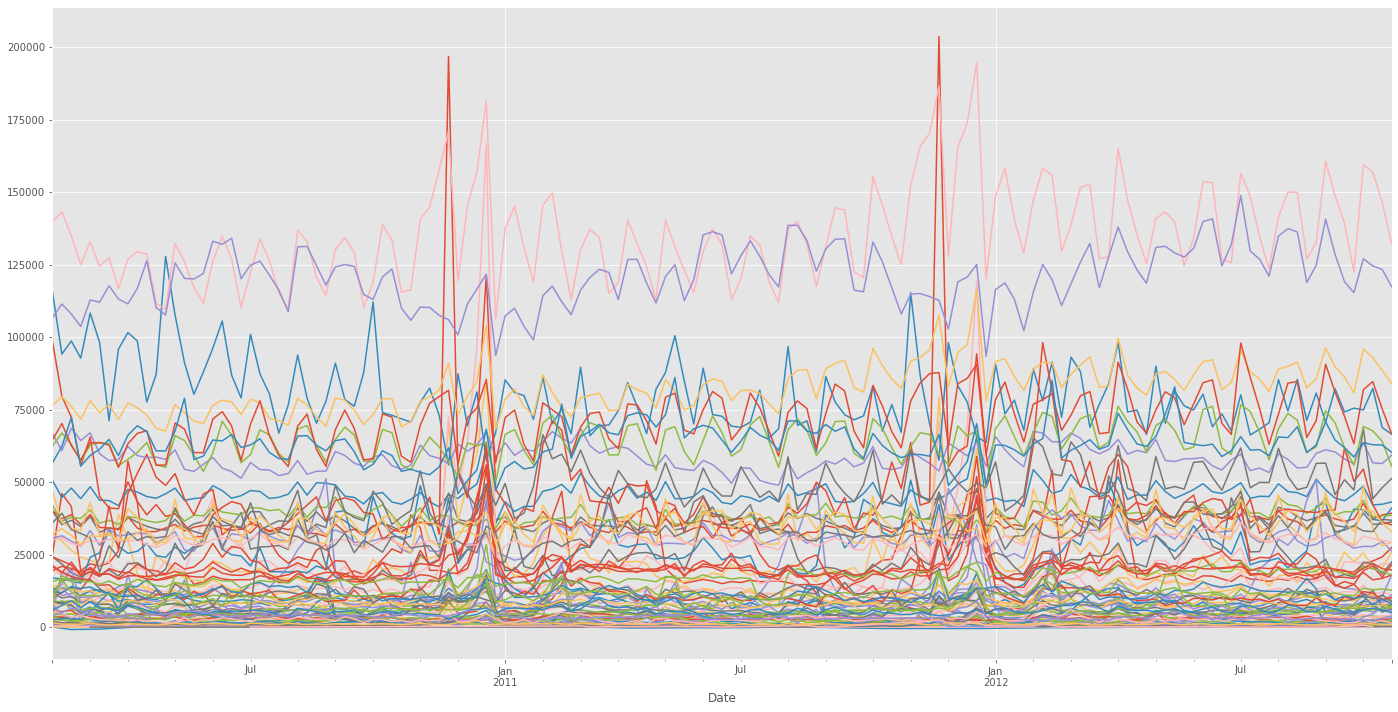

In [122]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

ts = train.copy()
ts.set_index("Date", drop = True, inplace = True)
ts = ts[ts["Store"] == 1]

plt.figure(figsize = (24, 12))
for i in ts.Dept.unique():
    ts[ts["Dept"] == i]['Weekly_Sales'].plot()

#### Weekly Sales by Department 1 in Store 1

<AxesSubplot:xlabel='Date'>

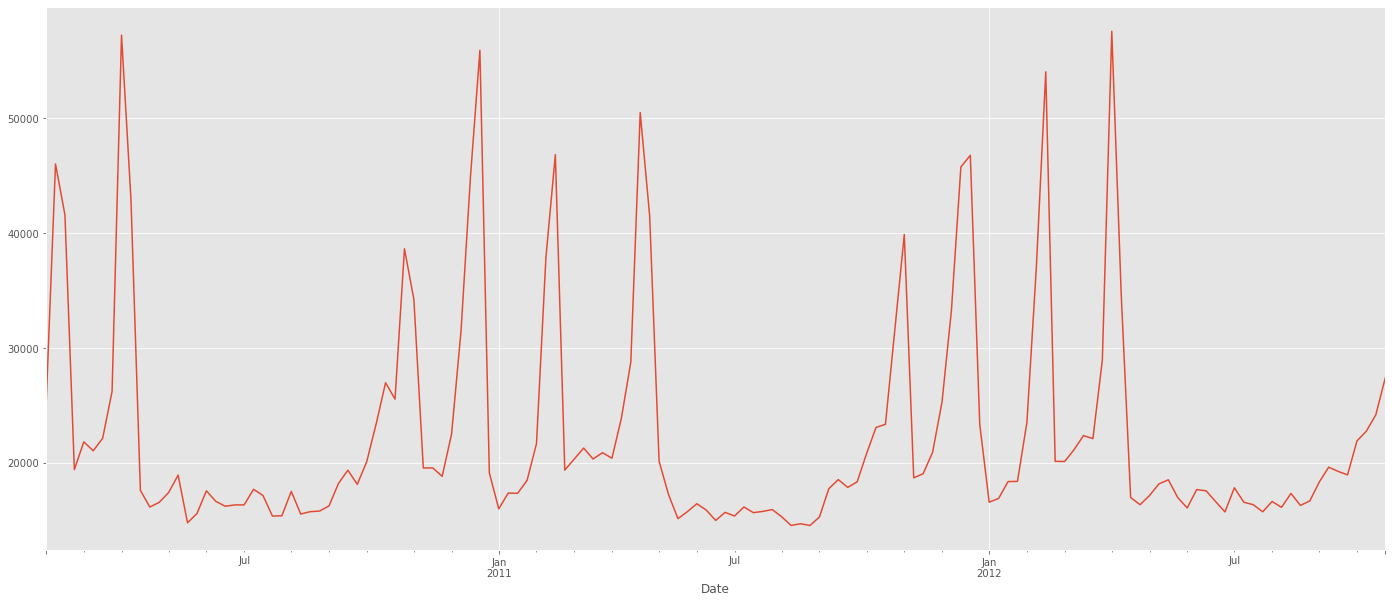

In [124]:
ts1 = ts[ts["Dept"] == 1]

plt.figure(figsize = (24, 10))
ts1["Weekly_Sales"].plot()

#### Stationarity
A time series is said to be "stationary" if it has no trend, exhibits constant variance over time, and has a constant autocorrelation structure over time. 

If the Dickey-Fuller test shows a significant p-value, the data is stationary, and, if not, the data has some time dependent structure. It seems obvious by the visualizations that the Weekly Sales data is non-stationary, with significant and reliable spikes in sales during specific points of the year.

In [126]:
from statsmodels.tsa.stattools import adfuller

dickey_fuller = adfuller(ts1['Weekly_Sales'], autolag = "AIC")
dickey_fuller_output = pd.Series(dickey_fuller[0:4], index=["T-Stat", "p-value", "# of Lags", "# of Observations"])

for key, value in dickey_fuller[4].items():
    dickey_fuller_output["Critical Value (%s)" % key] = value

print(dickey_fuller_output)

T-Stat                   -2.522164
p-value                   0.110174
# of Lags                 6.000000
# of Observations       136.000000
Critical Value (1%)      -3.479372
Critical Value (5%)      -2.883037
Critical Value (10%)     -2.578234
dtype: float64


#### Seasonality: Similarity of Annual Trend

In [146]:
ts1.head()

,Store,Dept,Weekly_Sales,IsHoliday,Month,Year
Date,,,,,,
2010-02-05,1,1,24924.50,False,Feb,2010
2010-02-12,1,1,46039.49,True,Feb,2010
2010-02-19,1,1,41595.55,False,Feb,2010
2010-02-26,1,1,19403.54,False,Feb,2010
2010-03-05,1,1,21827.90,False,Mar,2010


In [150]:
monthly_sales_data = pd.pivot_table(ts1, values = "Weekly_Sales", columns = "Year", index = "Month")
monthly_sales_data = monthly_sales_data.reindex(index = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
monthly_sales_data

Year,2010,2011,2012
Month,,,
Jan,NaN,17286.6475,17551.3375
Feb,32990.7700,31440.6575,33670.8250
Mar,22809.2850,20705.8350,22936.1080
Apr,30103.3520,33011.3900,31400.0300
May,16673.5375,17062.9300,17698.2450
Jun,16685.1750,15744.6425,16729.3080
Jul,16383.0020,15771.2460,16617.1975
Aug,16144.7025,14765.4875,16609.1140
Sep,17978.3175,17551.2820,19034.4750


<AxesSubplot:xlabel='Month'>

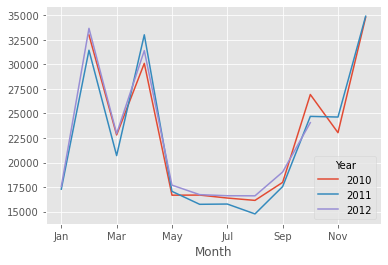

In [156]:
monthly_sales_data.plot()

#### Seasonality: Similarity of Monthly Distributions

In [159]:
yearly_sales_data = pd.pivot_table(ts1, values = "Weekly_Sales", columns = "Month", index = "Year")
yearly_sales_data = yearly_sales_data[['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
yearly_sales_data

Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2010,NaN,32990.7700,22809.285,30103.352,16673.5375,16685.1750,16383.0020,16144.7025,17978.3175,26928.9060,23040.3500,34796.776
2011,17286.6475,31440.6575,20705.835,33011.390,17062.9300,15744.6425,15771.2460,14765.4875,17551.2820,24701.7075,24634.3775,34902.414
2012,17551.3375,33670.8250,22936.108,31400.030,17698.2450,16729.3080,16617.1975,16609.1140,19034.4750,24061.1400,NaN,NaN


<AxesSubplot:>

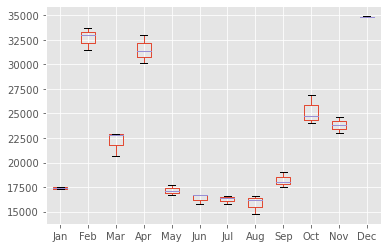

In [160]:
yearly_sales_data.boxplot()

#### Seasonality: Seasonal Decomposition

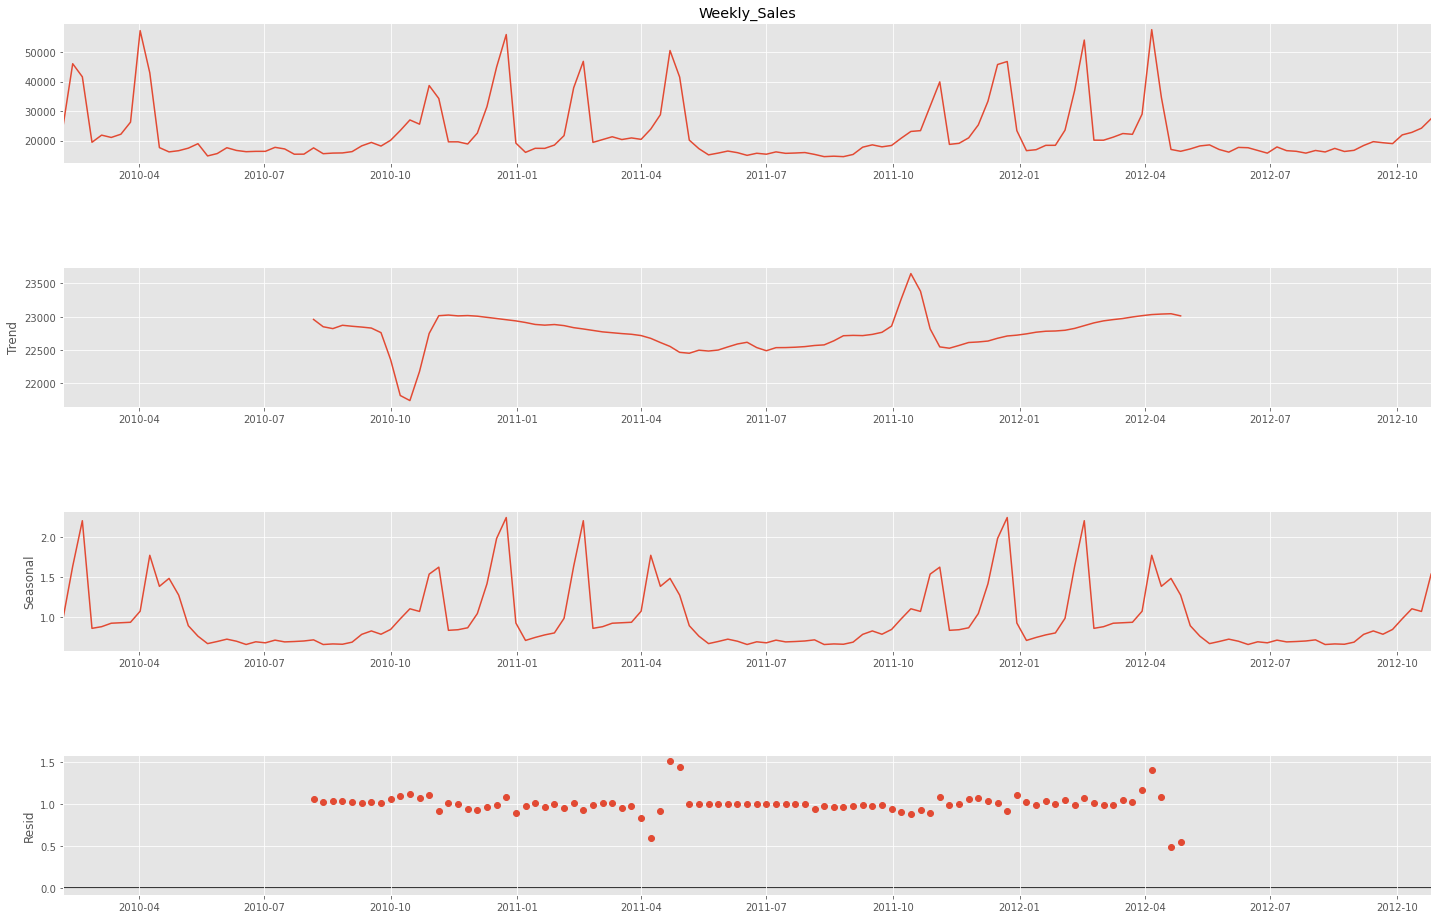

In [174]:
fig = sm.tsa.seasonal_decompose(ts1["Weekly_Sales"], model = "multiplicative").plot()

fig.set_figwidth(24)
fig.set_figheight(15)

plt.show()

### Seasonal Autoregressive Integrated Moving Average (SARIMA)

#### Autoregression

Text(0.5, 1.0, '1$^{st}$ Order Differencing')

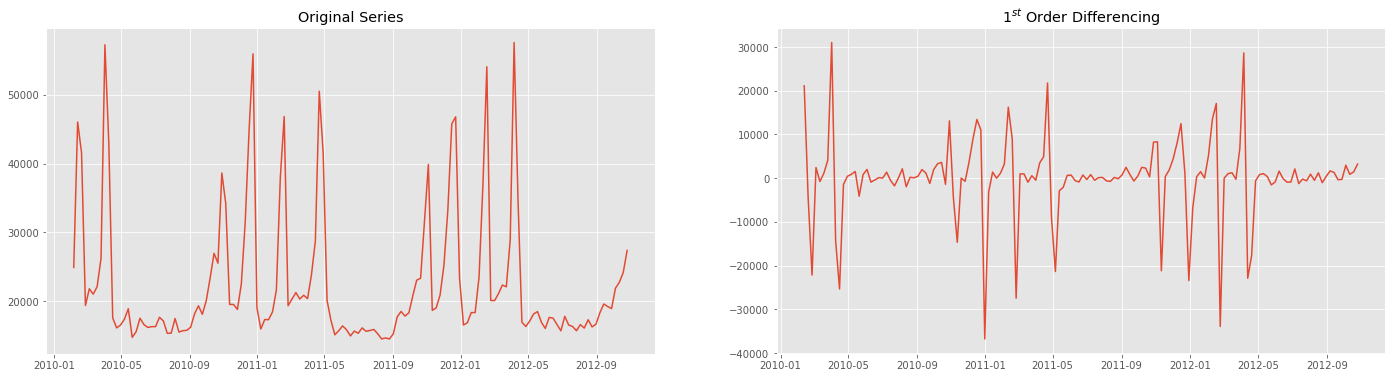

In [215]:
fig, ax = plt.subplots(1, 2, figsize = (24, 6))

# Original Series

ax[0].plot(ts1["Weekly_Sales"])
ax[0].set_title("Original Series")

# 1st Differencing

ax[1].plot(ts1["Weekly_Sales"].diff(periods = 1))
ax[1].set_title("1$^{st}$ Order Differencing")

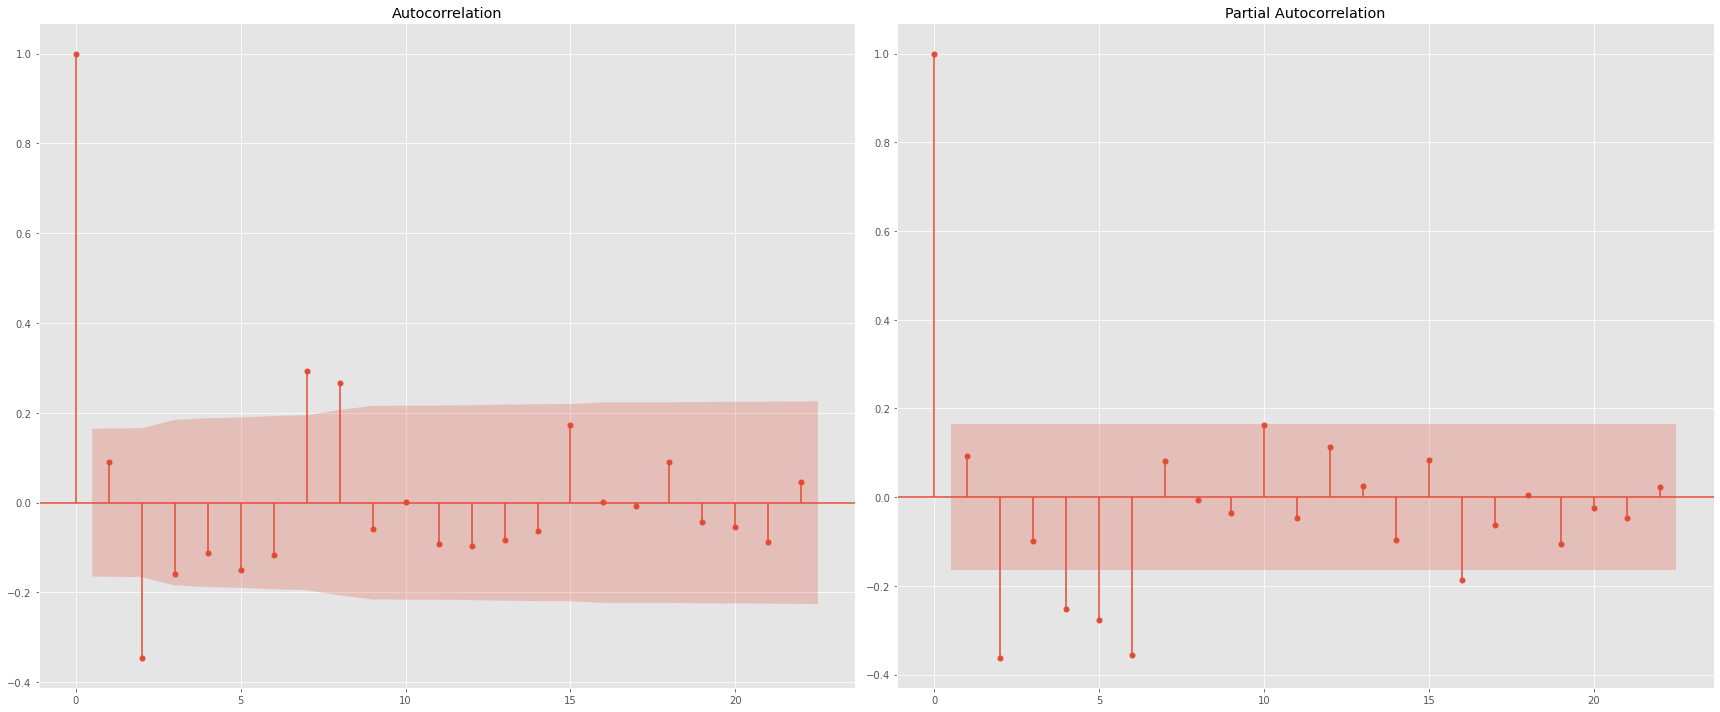

In [211]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

ts1_log = np.log10(ts1["Weekly_Sales"]).dropna()
ts1_log_diff = ts1_log.diff(periods = 1).dropna()

fig, ax = plt.subplots(1, 2, figsize = (24, 10))

plot_acf(ts1_log_diff, ax = ax[0])
plot_pacf(ts1_log_diff, ax = ax[1])

plt.tight_layout()

In [221]:
import itertools
import warnings
import sys
warnings.filterwarnings("ignore") 

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:  
        try:
            temp_model = sm.tsa.statespace.SARIMAX(ts1_log, order = param, seasonal_order = param_seasonal,
                                                   enforce_stationarity = True, enforce_invertibility = True)
            results = temp_model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            continue
            
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(1, 1, 1)x(0, 0, 0, 12)12 model - AIC:-196.93996783602557


In [223]:
best_model = sm.tsa.statespace.SARIMAX(ts1_log, order=(1, 1, 1), seasonal_order=(0, 0, 0, 12), 
                                       enforce_stationarity=True, enforce_invertibility=True)
best_results = best_model.fit()

In [224]:
print(best_results.summary().tables[0])
print(best_results.summary().tables[1])

                               SARIMAX Results                                
Dep. Variable:           Weekly_Sales   No. Observations:                  143
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 101.470
Date:                Mon, 19 Sep 2022   AIC                           -196.940
Time:                        21:28:54   BIC                           -188.072
Sample:                    02-05-2010   HQIC                          -193.337
                         - 10-26-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5068      0.165     -3.063      0.002      -0.831      -0.182
ma.L1          0.7435      0.134      5.563      0.000       0.482       1.006
sigma2         0.0140      0.001     13.990      0.0

In [250]:
print("Maximum date =", ts1_log.index.max())

Maximum date = 2012-10-26 00:00:00


In [236]:
forecast = best_results.get_prediction(start = pd.to_datetime("2012-06-01"), dynamic = True, full_results = True)
forecast_CI = forecast.conf_int()

In [265]:
from sklearn.metrics import mean_squared_error
from math import sqrt

MSE = mean_squared_error(ts1_log["2012-06-01":], forecast.predicted_mean)
RMSE = sqrt(MSE)

print("MSE = {:.4f}".format(MSE))
print("RMSE = {:.4f}".format(RMSE))

MSE = 0.0053
RMSE = 0.0730


In [267]:
pred_95 = best_results.get_forecast(steps = 36, alpha = 0.01)
pred_95_CI = pred_95.conf_int()

In [271]:
idx = pd.date_range(ts1.index[-1], periods = 36, freq = 'MS')

fc_95 = pd.DataFrame(np.column_stack([np.power(10, pred_95.predicted_mean), np.power(10, pred_95_CI)]), 
                     index = idx, columns = ["forecast", "lower_95_CI", "upper_95_CI"])

fc_95.head()

,forecast,lower_95_CI,upper_95_CI
2012-11-01,27758.174789,16271.425904,47353.948704
2012-12-01,27571.395650,11790.289509,64475.249526
2013-01-01,27665.891106,9798.128937,78117.111502
2013-02-01,27617.963745,8205.178711,92959.818221
2013-03-01,27642.241251,7098.215769,107645.854426


In [272]:
ts1.head()

,Store,Dept,Weekly_Sales,IsHoliday,Month,Year
Date,,,,,,
2010-02-05,1,1,24924.50,False,Feb,2010
2010-02-12,1,1,46039.49,True,Feb,2010
2010-02-19,1,1,41595.55,False,Feb,2010
2010-02-26,1,1,19403.54,False,Feb,2010
2010-03-05,1,1,21827.90,False,Mar,2010


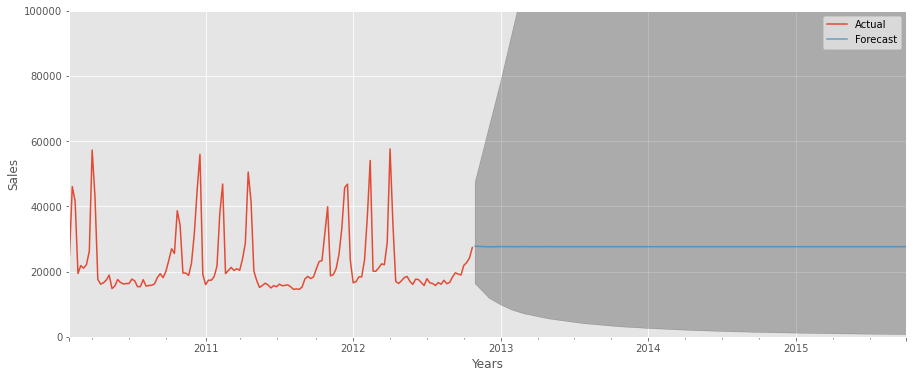

In [277]:
axis = ts1["Weekly_Sales"].plot(label = "Actual", figsize = (15, 6))
fc_95["forecast"].plot(ax = axis, label = "Forecast", alpha=0.7)

axis.fill_between(fc_95.index, fc_95["lower_95_CI"], fc_95["upper_95_CI"], color = "k", alpha = 0.25)

axis.set_xlabel("Years")
axis.set_ylabel("Sales")
plt.legend(loc = "best")

plt.ylim(0, 100000)

plt.show()